<a href="https://colab.research.google.com/github/Jingut/GoingDeeper/blob/main/GD2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 

최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 

데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 

결과를 수치화하고 비교하는 것도 잊지 마세요!



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##1. Augmentation을 적용한 데이터셋 만들기
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.



In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteUHDFON/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteUHDFON/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


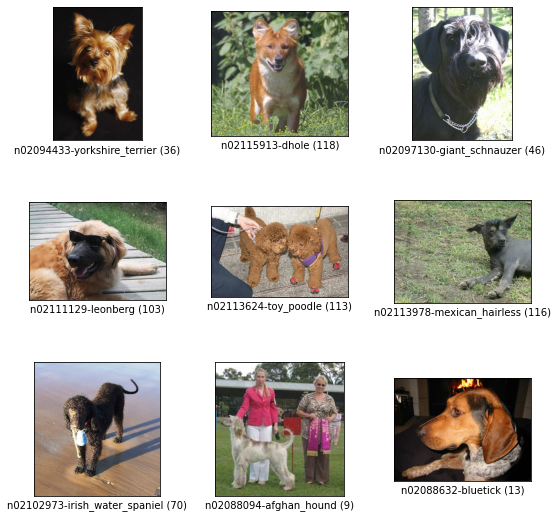

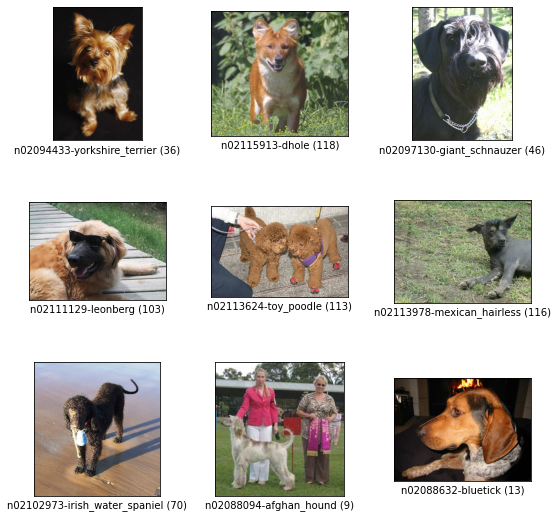

In [4]:
tfds.show_examples(ds_train, ds_info) # 데이터 확인 

In [5]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [6]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

In [7]:
print(ds_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


# Augmentation적용하기

#CutMix 함수구현

In [8]:
def normalize_and_resize_img(image, label): # 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize한다.
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label): # random_flip_left_right() 과 random_brightness() 를 활용
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label, num_classes = 120):
    label_oh = tf.one_hot(label, num_classes)
    return image, label_oh

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

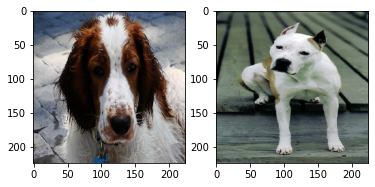

In [9]:
import matplotlib.pyplot as plt

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(152, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(128, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


#Cutmix 사용을위한 데이터 섞기

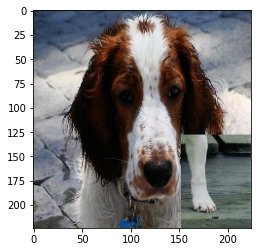

In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#훈련데이터에 맞춰 라벨데이터도 섞어주기

In [12]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.1377551,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.8622449, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [13]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

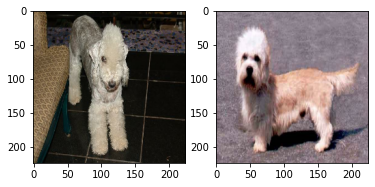

In [14]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

#Mixup Augmentation

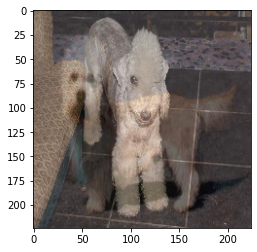

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.6113498  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.38865018 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

#배치 단위의 Mixup 함수 구현

In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

##2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [17]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [18]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [19]:
# 데이터셋에서 이미지 가져와서 시각화
def draw_ds_train(ds_train, batch_size=16, row=6, col=4):
    row = min(row, batch_size//col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize=(8,int(8*row/col)))  # 8x8 크기
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

#No Aug

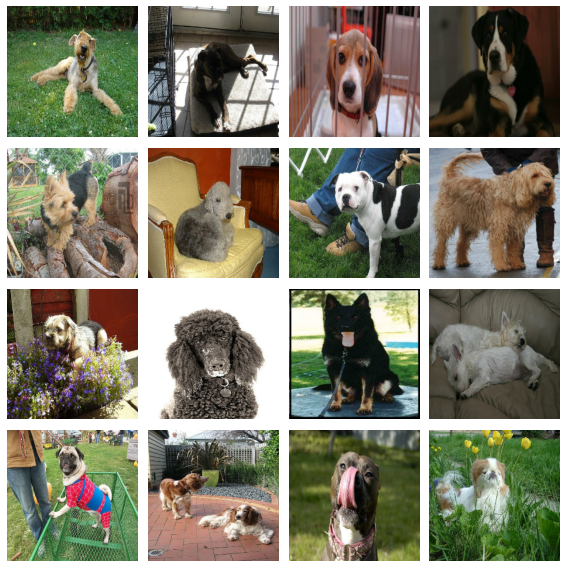

In [20]:
draw_ds_train(ds_train_no_aug, 16)

#Aug

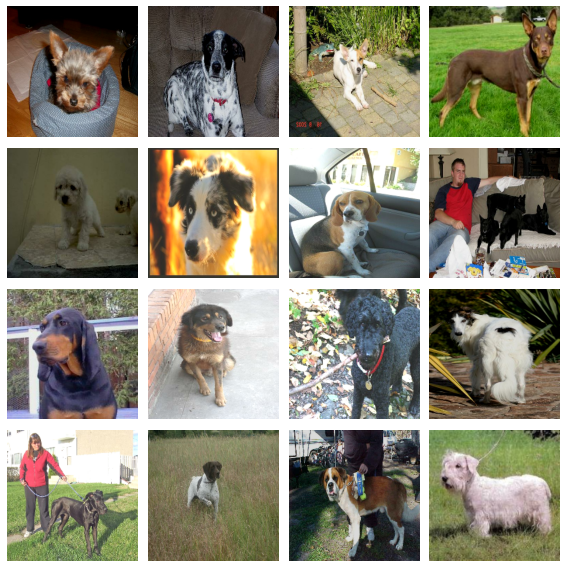

In [21]:
draw_ds_train(ds_train_aug, 16)

#Mixup

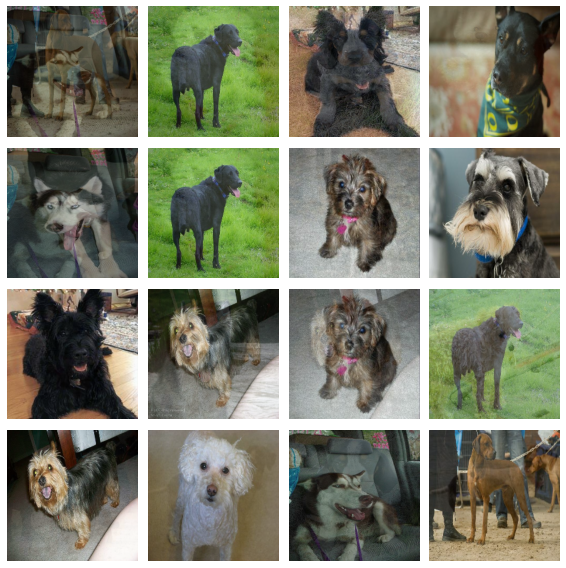

In [22]:
draw_ds_train(ds_train_mixup, 16)

#Cutmix

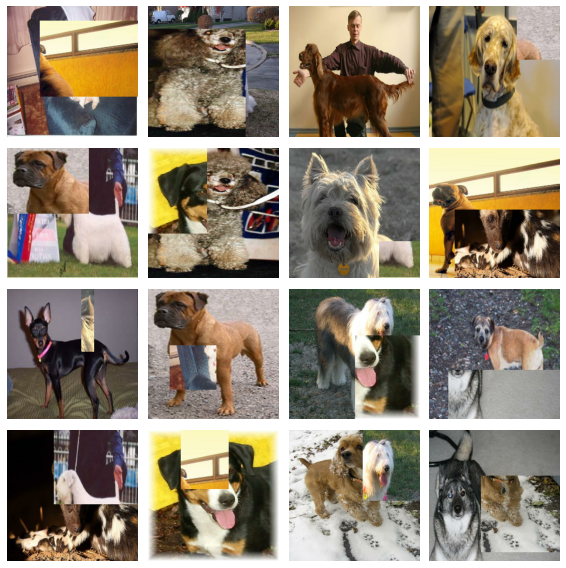

In [23]:
draw_ds_train(ds_train_cutmix, 16)

# Augmentation을 적용한 데이터셋으로 학습 시킬모델

In [24]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Augmetation을 적용하지 않은 데이터셋으로 학습시킬 모델


In [25]:
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

#CutMix

In [26]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#Mixup


In [27]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 

앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 

sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고,

다른 하나는 True로 주어 augmentation이 적용되도록 합니다

In [28]:
EPOCH = 20

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 111s 122ms/step - loss: 2.2720 - accuracy: 0.4285 - val_loss: 3.0684 - val_accuracy: 0.2508
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.9726 - accuracy: 0.7194 - val_loss: 1.3979 - val_accuracy: 0.6067
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 0.5249 - accuracy: 0.8548 - val_loss: 1.1000 - val_accuracy: 0.6803
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.2606 - accuracy: 0.9387 - val_loss: 1.0246 - val_accuracy: 0.7001
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1316 - accuracy: 0.9763 - val_loss: 0.9465 - val_accuracy: 0.7284
Epoch 6/20
750/750 [==============================] - 92s 123ms/step - loss: 0.0785 - accuracy: 0.9887 - val_loss: 0.9954 - val_accuracy: 0.7252
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 0.0437 - accuracy: 0.9951 - val_loss: 0.9952 - val_accuracy: 0.

In [29]:
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 122ms/step - loss: 2.2168 - accuracy: 0.4408 - val_loss: 2.9469 - val_accuracy: 0.2734
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.6725 - accuracy: 0.8208 - val_loss: 1.1024 - val_accuracy: 0.6770
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 0.1833 - accuracy: 0.9646 - val_loss: 0.9720 - val_accuracy: 0.7122
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0469 - accuracy: 0.9976 - val_loss: 0.8950 - val_accuracy: 0.7386
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0197 - accuracy: 0.9998 - val_loss: 0.9112 - val_accuracy: 0.7407
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.9211 - val_accuracy: 0.7414
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.9327 - val_ac

In [30]:
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 120ms/step - loss: 2.2185 - accuracy: 0.4461 - val_loss: 3.3767 - val_accuracy: 0.1995
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.6956 - accuracy: 0.8127 - val_loss: 1.1831 - val_accuracy: 0.6604
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2515 - accuracy: 0.9464 - val_loss: 0.9926 - val_accuracy: 0.7095
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0886 - accuracy: 0.9881 - val_loss: 0.9454 - val_accuracy: 0.7285
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0299 - accuracy: 0.9983 - val_loss: 0.9250 - val_accuracy: 0.7403
Epoch 6/20
750/750 [==============================] - 90s 119ms/step - loss: 0.0129 - accuracy: 0.9999 - val_loss: 0.9285 - val_accuracy: 0.7424
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.9398 - val_ac

In [31]:
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 120ms/step - loss: 2.2870 - accuracy: 0.4295 - val_loss: 2.9235 - val_accuracy: 0.2808
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 0.9201 - accuracy: 0.7373 - val_loss: 1.1573 - val_accuracy: 0.6649
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.4800 - accuracy: 0.8690 - val_loss: 1.1839 - val_accuracy: 0.6666
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2524 - accuracy: 0.9412 - val_loss: 0.9740 - val_accuracy: 0.7215
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 0.1305 - accuracy: 0.9775 - val_loss: 0.9631 - val_accuracy: 0.7310
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0734 - accuracy: 0.9906 - val_loss: 0.9442 - val_accuracy: 0.7327
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0431 - accuracy: 0.9950 - val_loss: 0.9553 - val_ac

##4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

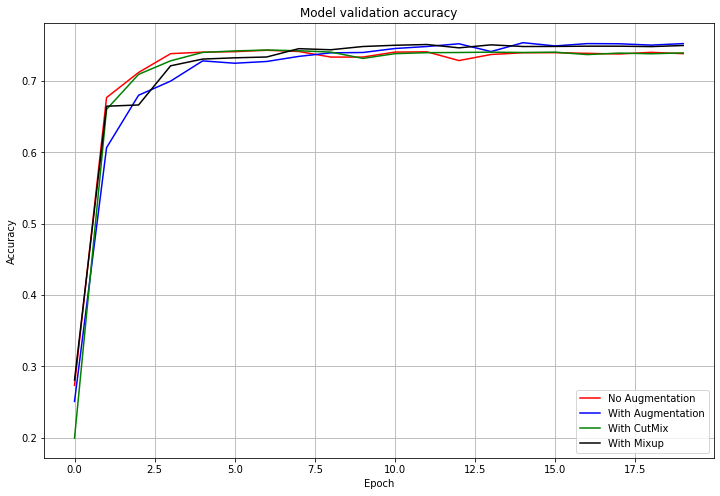

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

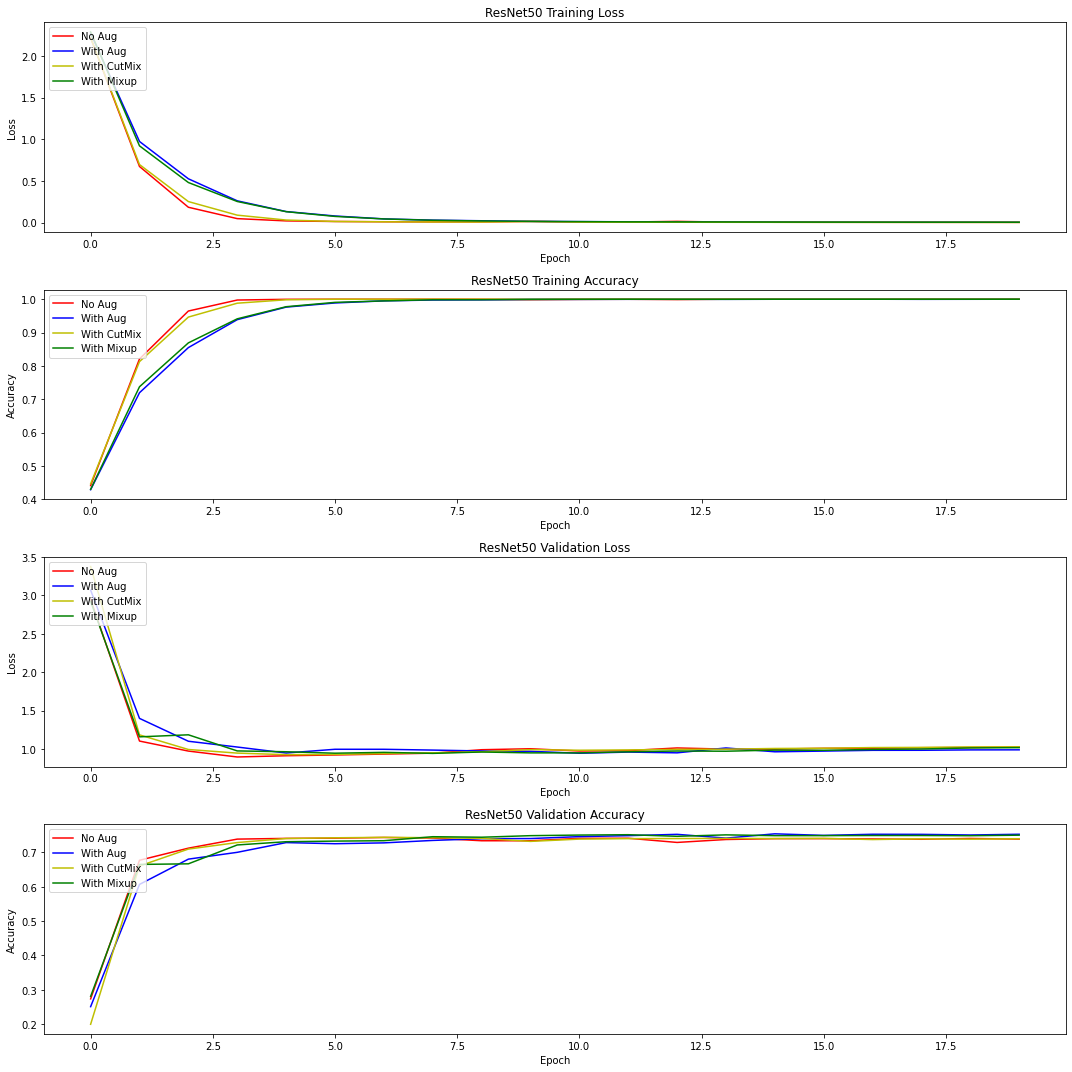

In [33]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.show()

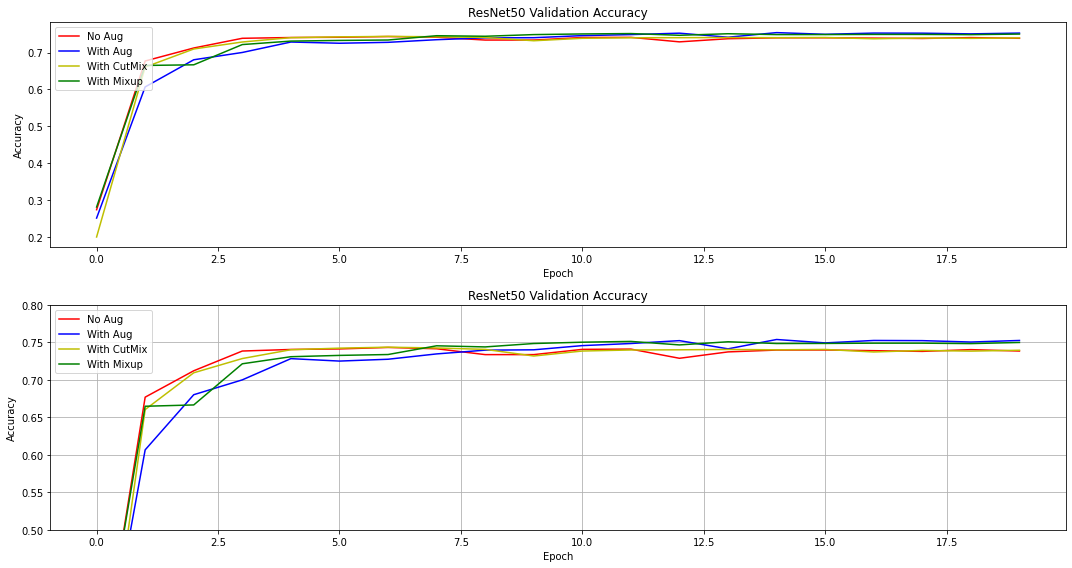

In [34]:
plt.subplots(figsize=(15,8))

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화
plt.subplot(211)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화 2
plt.subplot(212)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.tight_layout()
plt.show()

#5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, 

Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [35]:
import pandas as pd
def get_df_resnet50_result(col='val_accuracy'):
    # ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 저장
    resnet50 = {
        'No Aug': history_resnet50_no_aug.history[col],
        'With Aug': history_resnet50_aug.history[col],
        'With CutMix': history_resnet50_cutmix.history[col],
        'With Mixup': history_resnet50_mixup.history[col]
    }

    # 데이터 프레임으로 생성
    df_resnet50 = pd.DataFrame(resnet50, index=[f'EPOCHS_{i}' for i in range(EPOCH)])
    return df_resnet50

In [36]:
df_resnet50_loss = get_df_resnet50_result('loss')
df_resnet50_loss

No Aug  With Aug  With CutMix  With Mixup
EPOCHS_0   2.216846  2.271990     2.218534    2.286991
EPOCHS_1   0.672478  0.972587     0.695582    0.920073
EPOCHS_2   0.183329  0.524855     0.251535    0.480044
EPOCHS_3   0.046887  0.260598     0.088645    0.252432
EPOCHS_4   0.019713  0.131623     0.029901    0.130463
EPOCHS_5   0.012465  0.078541     0.012930    0.073420
EPOCHS_6   0.009405  0.043675     0.008785    0.043052
EPOCHS_7   0.007552  0.028912     0.006986    0.027008
EPOCHS_8   0.007273  0.021281     0.006392    0.019085
EPOCHS_9   0.013449  0.014182     0.013383    0.013570
EPOCHS_10  0.007422  0.011209     0.005434    0.010955
EPOCHS_11  0.006015  0.008942     0.003948    0.008135
EPOCHS_12  0.014151  0.007124     0.003434    0.007465
EPOCHS_13  0.005085  0.006799     0.003047    0.006563
EPOCHS_14  0.003260  0.005473     0.002753    0.005560
EPOCHS_15  0.002839  0.004612     0.002552    0.004753
EPOCHS_16  0.002543  0.003997     0.002352    0.004264
EPOCHS_17  0.002317  0.004410     0.002198    0.003642
EPOCHS_18  0.002139  0.004088     0.002050    0.003737
EPOCHS_19  0.001992  0.003289     0.001909    0.003247

In [37]:
df_resnet50_val_accuracy = get_df_resnet50_result('val_accuracy')
df_resnet50_val_accuracy

No Aug  With Aug  With CutMix  With Mixup
EPOCHS_0   0.273438  0.250816     0.199510    0.280784
EPOCHS_1   0.677006  0.606693     0.660448    0.664879
EPOCHS_2   0.712220  0.680270     0.709538    0.666628
EPOCHS_3   0.738573  0.700093     0.728545    0.721548
EPOCHS_4   0.740672  0.728428     0.740322    0.730993
EPOCHS_5   0.741371  0.725163     0.742421    0.732743
EPOCHS_6   0.743354  0.727612     0.743703    0.733909
EPOCHS_7   0.741605  0.734725     0.742654    0.745569
EPOCHS_8   0.733792  0.739739     0.740788    0.744053
EPOCHS_9   0.733792  0.740205     0.731926    0.748601
EPOCHS_10  0.740788  0.745802     0.738573    0.750350
EPOCHS_11  0.741138  0.748601     0.739972    0.751399
EPOCHS_12  0.728895  0.752449     0.740205    0.746735
EPOCHS_13  0.737407  0.741488     0.740672    0.750933
EPOCHS_14  0.739855  0.753965     0.740205    0.748601
EPOCHS_15  0.739972  0.749417     0.740672    0.748717
EPOCHS_16  0.739039  0.752682     0.737290    0.749067
EPOCHS_17  0.738106  0.752449     0.739389    0.749067
EPOCHS_18  0.740438  0.750583     0.738456    0.748484
EPOCHS_19  0.738573  0.752682     0.739622    0.750000

#결론
이번에는 데이터 Augmentation을 통해 데이터를 여러방식으로 증가시켜보는 프로젝트를 진행 해보았습니다.

데이터셋은 standord_dogs를 이용하였고 클래스는 120개 였습니다. 

No_Aug, Aug, Cutmix, Mixup 총 네가지를 비교해보았을 때 20 에포크 기준 이상하게도 손실함수 값을 비교하였을 때 어그멘테이션을 진행하지 않은 것이 결과물이 가장 좋았고, 다음으로 Mixup, 일반 Aug, Cutmix 로스가 낮았습니다.



# 회고

---



## - 이번 프로젝트에서 어려웠던 점
네가지 No_Aug, Aug, Mixup, Cutmix 등을 직접 비교해 보았지만 이론상으로는 어그멘테이션은 어느정도 완벽했지만 실제로 결과는 좋게 나오지 못해 아쉬웠습니다.



---


## - 프로젝트를 진행하면서 알게된 점

- 느낀점

결과물을 보면 알 수 있다시피 오히려 데이터 증강을 적용하면 할 수록 loss값이 높아지는 것을 확인 할 수 있었는데 이를 통해 무조건적인 데이터 증강이 좋지는 않다고 생각했습니다. 

- 데이터 어그멘테이션 이란?

데이터를 증강하는것,  데이터를  로버스트하게 학습을 시키기 위해 기존의 데이터를 변형 하는것.

- 데이터 어그멘테이션의 단점

간혹 어그멘테이션 후의 결과가 올바르지 못한 방향으로 학습이 될 때
Ex) 숫자 이미지 데이터에서 예시로 6이라는 숫자 이미지를 학습 시킬 때 180도 회전 후 반전시키는 augmentation을 진행할 때 9를 6의 이미지라고 학습 시키게 되는 경우가 발생한다.

이런 경우에는 데이터를 가공하는 사람이 사전에 데이터를 모두 확인하고 이러한 사항이 발생할지 미연에 방지하는 쪽으로 한다.

- 어그멘테이션이 필요하지 않을 때

데이터가 학습 시키기에 양이 충분히 많을 때, 위와 같이 이상현상이 발생할 때   


---


## - 루브릭 평가지표를 맞추기 위해 시도한 것들

ResNet50 모델에 No Aug, With Aug, With CutMix, With Mixup 적용시켜 학습시켜 보았습니다. 

여러 Augmentation 기법을 적용했을 때보다 적용하지 않은 쪽이 loss값이 더 낮게 나왔습니다.

학습결과를 선 그래프로 시각화 해보았고, 

validation accuracy 평균 값을 통해 어떤 데이터셋의 성능이 높게 평가되는지 확인해 보았을 때

결과적으로 기본 Aug 데이터셋이 가장 validation accuracy가 가장 높았습니다.


---


## - 자기다짐
수치도 중요하지만 실제 결과물도 중요하다!

